In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

## 12.5.1 Principal Components Analysis

In [2]:
USArrests = pd.read_csv('../data/USArrests.csv', index_col=0)
USArrests.head()

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [3]:
states = USArrests.columns
states

Index(['Murder', 'Assault', 'UrbanPop', 'Rape'], dtype='object')

In [4]:
USArrests.mean()

Murder        7.788
Assault     170.760
UrbanPop     65.540
Rape         21.232
dtype: float64

We notice that the variables have vastly different means. We see that there are on average three times as many rapes as murders, and more than eight times as many assaults as rapes.

In [5]:
USArrests.var()

Murder        18.970465
Assault     6945.165714
UrbanPop     209.518776
Rape          87.729159
dtype: float64

Not surprisingly, the variables also have vastly different variances: the `UrbanPop` variable measures the percentage of the population in each state living in an urban area, which is not a comparable number to the number of rapes in each state per 100,000 individuals.

If we failed to scale the variables before performing PCA, then most of the principal components that we observed would be driven by the `Assault` variable, since it has by far the largest mean and variance. Thus, it is important to standardize the variables to have mean zero and standard deviation one before performing PCA.

In [6]:
# scale the data

scaler = StandardScaler()

USArrests_scaled = scaler.fit_transform(USArrests)

In [7]:
pca = PCA()
pr_out = pca.fit(USArrests_scaled)

In [8]:
# Principal component loading vectors
loading_vectors = pr_out.components_
features = list(USArrests.columns)
pd.DataFrame(loading_vectors, index=['PC1', 'PC2', 'PC3', 'PC4'], columns=features).T

,PC1,PC2,PC3,PC4
Murder,0.535899,0.418181,-0.341233,0.649228
Assault,0.583184,0.187986,-0.268148,-0.743407
UrbanPop,0.278191,-0.872806,-0.378016,0.133878
Rape,0.543432,-0.167319,0.817778,0.089024


In [9]:
# Principale component score vectors
pr_out.transform(USArrests_scaled).shape

(50, 4)

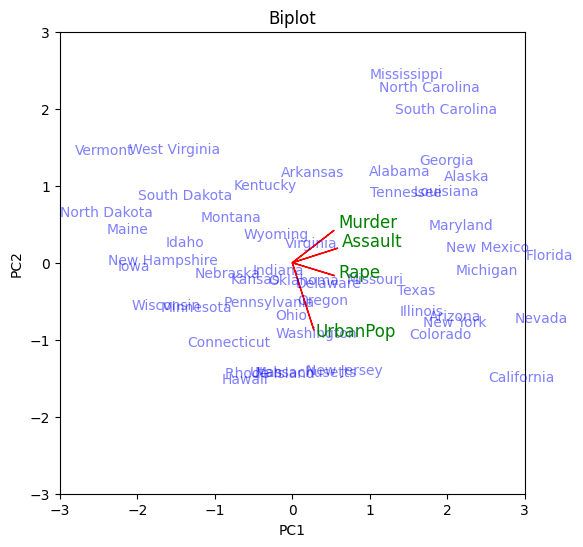

In [10]:
# extract the scores of the first two principal components
scores = pr_out.transform(USArrests_scaled)[:, :2]

ldngs = pr_out.components_[:2, ]
features = list(USArrests.columns)
index_names = USArrests.index.to_list()

plt.figure(figsize=(6,6))
for i, (x, y) in enumerate(scores):
    plt.text(x, y, index_names[i], color='b', alpha=0.5)
    
for i, feature in enumerate(features):
    plt.arrow(0, 0, ldngs[0, i], ldngs[1, i], color='r')
    plt.text(ldngs[0, i] * 1.1, ldngs[1, i]* 1.1, feature, color='g', fontsize=12)
    
plt.xlim(-3, 3)  
plt.ylim(-3, 3)  

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot')

plt.show()

In [11]:
# the variance explained by each principal component
pr_out.explained_variance_

array([2.53085875, 1.00996444, 0.36383998, 0.17696948])

In [12]:
# the proportion of the variance explained by each principal component
pve = pr_out.explained_variance_ratio_
pve

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

We see that the first principal component explains 62.0% of the variance in the data, the next principal component explains 24.7 % of the variance, and so forth.

Text(0, 0.5, 'Cumulative Proportion of Variance Explained')

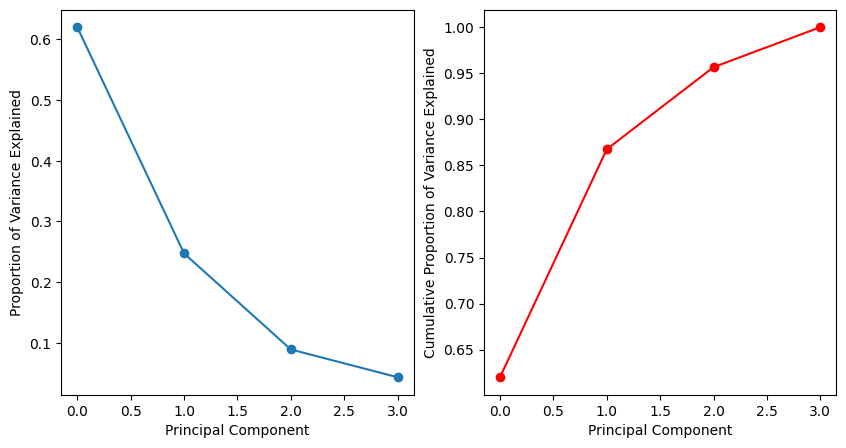

In [13]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(pve, marker='o')
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Proportion of Variance Explained')

ax[1].plot(np.cumsum(pve), marker='o', color='r')
ax[1].set_xlabel('Principal Component')
ax[1].set_ylabel('Cumulative Proportion of Variance Explained')

## 12.5.2 Matrix Completion

In [14]:
scaler = StandardScaler()
X = scaler.fit_transform(USArrests)

In [15]:
pca = PCA()
pcob = pca.fit(X)

In [16]:
std_dev = pcob.explained_variance_
pve = pcob.explained_variance_ratio_
cum_pve = np.cumsum(pve)

summary = pd.DataFrame({
    'Standard Deviation': std_dev,
    'Proportion of Variance': pve,
    'Cumulative Proportion': cum_pve
}, index=['PC{}'.format(i + 1) for i in range(pcob.n_components_)])

summary.T

,PC1,PC2,PC3,PC4
Standard Deviation,2.530859,1.009964,0.363840,0.176969
Proportion of Variance,0.620060,0.247441,0.089141,0.043358
Cumulative Proportion,0.620060,0.867502,0.956642,1.000000


We saw in Section 12.2.2 that solving the optimization problem (12.6) on a centered data matrix X is equivalent to computing the first M principal components of the data. The singular value decomposition (SVD) is a general algorithm for solving (12.6).

In [17]:
sX = np.linalg.svd(X, full_matrices=False)
rounded_v = np.round(sX[2], 3).T
print(rounded_v)

[[-0.536 -0.418  0.341  0.649]
 [-0.583 -0.188  0.268 -0.743]
 [-0.278  0.873  0.378  0.134]
 [-0.543  0.167 -0.818  0.089]]


In [18]:
loading_vectors = pcob.components_
features = list(USArrests.columns)
pd.DataFrame(loading_vectors, index=['PC1', 'PC2', 'PC3', 'PC4'], columns=features).T

,PC1,PC2,PC3,PC4
Murder,0.535899,0.418181,-0.341233,0.649228
Assault,0.583184,0.187986,-0.268148,-0.743407
UrbanPop,0.278191,-0.872806,-0.378016,0.133878
Rape,0.543432,-0.167319,0.817778,0.089024


In [19]:
# create new matrix which contains missing values
np.random.seed(62)

nomit = 20
ina = np.random.choice(range(1, 50), nomit, replace=False)
inb = np.random.choice(range(1,3), nomit, replace=True)

Xna = X.copy()
index_na = np.column_stack((ina, inb))
Xna[tuple(index_na.T)] = np.nan

In [20]:
# @ - matrix multiplication
def fit_svd(X, M=1):
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    return U[:, :M] @ (np.diag(s[:M]) @ Vt[:M, :])

In [21]:
# replacing the missing values with the column means of the non-missing entries
Xhat = Xna.copy()
xbar = np.nanmean(Xna, axis=0)
Xhat[tuple(index_na.T)] = xbar[inb]

In [22]:
thresh = 1e-7
rel_err = 1
it = 0 # iter
ismiss = np.isnan(Xna)
mssold = np.mean((np.nan_to_num(Xna) -xbar)**2)
mss0 = np.mean(np.nan_to_num(Xna) **2)

In [23]:
while (rel_err > thresh):
    it += 1
    # Step 2(a)
    Xapp = fit_svd(Xhat, M=1)
    # Step 2(b)
    Xhat[ismiss] = Xapp[ismiss]
    # Step 2(c)
    mss = np.mean(((Xna - Xapp)[~ismiss])**2)
    rel_err = (mssold - mss) / mss0
    mssold = mss
    print("Iter:", it, "MSS:", mss, "Rel. Err:", rel_err)

Iter: 1 MSS: 0.38478674145018893 Rel. Err: 0.5671838318681058
Iter: 2 MSS: 0.3708337382182252 Rel. Err: 0.015670911003363708
Iter: 3 MSS: 0.3684937068069396 Rel. Err: 0.002628138428817015
Iter: 4 MSS: 0.3679395542224598 Rel. Err: 0.0006223804072354662
Iter: 5 MSS: 0.36778367636098347 Rel. Err: 0.00017506970033476086
Iter: 6 MSS: 0.36773609118293266 Rel. Err: 5.344391296385846e-05
Iter: 7 MSS: 0.3677209711404366 Rel. Err: 1.6981637313732708e-05
Iter: 8 MSS: 0.36771606588901434 Rel. Err: 5.50919090389399e-06
Iter: 9 MSS: 0.3677144565081163 Rel. Err: 1.8075294905731617e-06
Iter: 10 MSS: 0.3677139251742838 Rel. Err: 5.967521875801756e-07
Iter: 11 MSS: 0.3677137491398232 Rel. Err: 1.97708000208344e-07
Iter: 12 MSS: 0.36771369070285614 Rel. Err: 6.563178511570863e-08


In [24]:
# we compute the correlation between the 20 imputed values and the actual values
correlation_matrix = np.corrcoef(Xapp[ismiss], X[ismiss])
correlation = correlation_matrix[0, 1]

print("Correlation:", correlation)

Correlation: 0.7070716056129264


## 12.5.3 Clustering
### K-Means Clustering

In [2]:
np.random.seed(2)

x = np.random.randn(50, 2)
x[:25, 0] = x[:25, 0] + 3
x[:25, 1] = x[:25, 1] - 4

In [3]:
# K = 2
kmeans = KMeans(n_clusters=2, n_init=20)
kmeans.fit(x)

KMeans(n_clusters=2, n_init=20)

In [4]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1], dtype=int32)

Text(0, 0.5, 'Y')

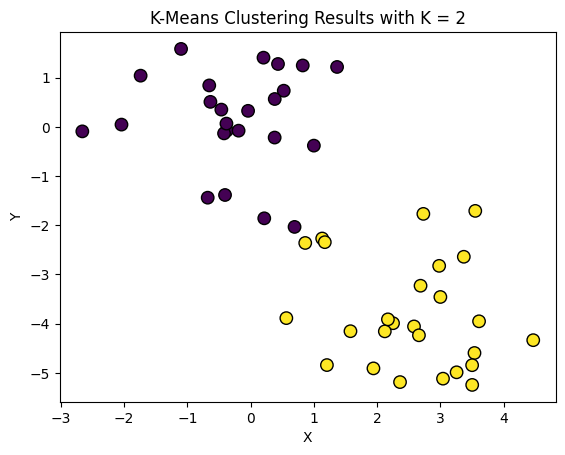

In [5]:
plt.scatter(x[:, 0], x[:, 1], c=kmeans.labels_ + 1, cmap='viridis', edgecolor='k', s=80)
plt.title("K-Means Clustering Results with K = 2")
plt.xlabel("X")
plt.ylabel("Y")

In [6]:
# K = 3
kmeans2 = KMeans(n_clusters=3, n_init=20, random_state=2)
kmeans2.fit(x)
kmeans2.labels_

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2,
       0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 2], dtype=int32)

In [7]:
# Cluster centroids
kmeans2.cluster_centers_

array([[ 2.82364474, -4.0069323 ],
       [-0.27876523,  0.51224152],
       [ 0.44551812, -2.19693223]])

In [8]:
# Within cluster sum of squares by cluster
kmeans2.inertia_

69.42547524486457

Text(0, 0.5, 'Y')

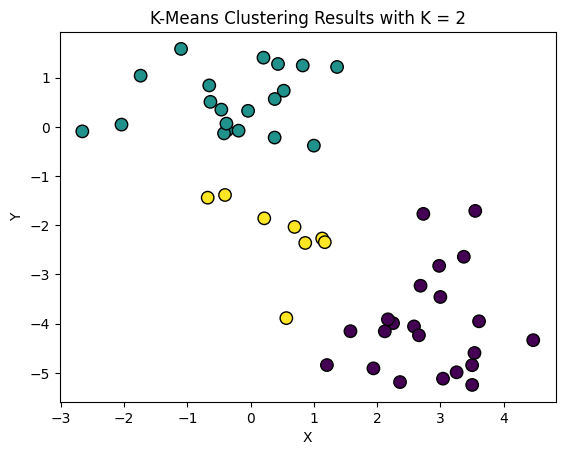

In [9]:
plt.scatter(x[:, 0], x[:, 1], c=kmeans2.labels_ + 1, cmap='viridis', edgecolor='k', s=80)
plt.title("K-Means Clustering Results with K = 2")
plt.xlabel("X")
plt.ylabel("Y")

In [10]:
# Compare the impact of the n_init parameter on the fitting procedure.
# This parameter determines the number of multiple initial cluster 
# assignments that will be used.

kmout = KMeans(n_clusters=3, n_init=1, random_state=12)
kmout2 = KMeans(n_clusters=3, n_init=20, random_state=12)
kmout.fit(x), kmout2.fit(x)

kmout.inertia_, kmout2.inertia_

(69.84341701350976, 68.97379200939724)

### Hierarchical Clustering

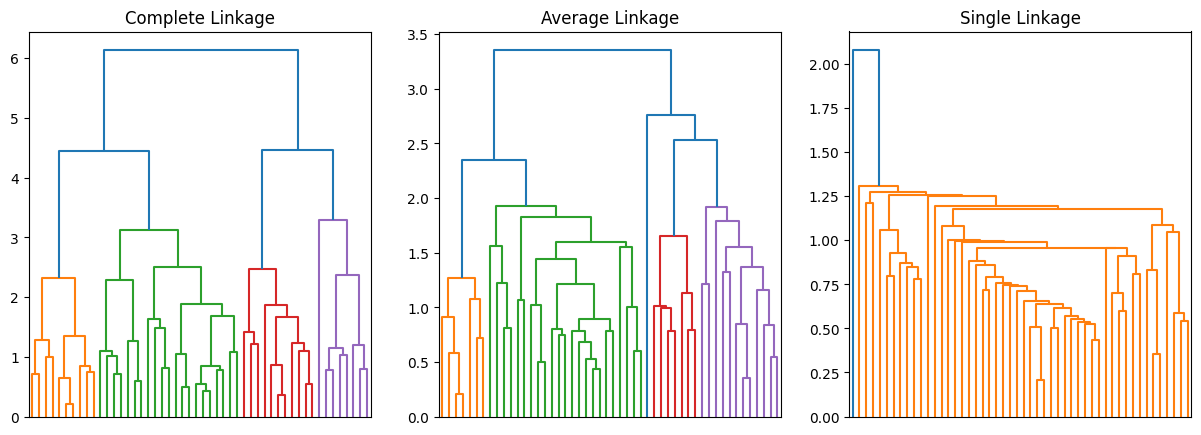

In [34]:
data = pdist(X, metric='euclidean')

hc_complete = linkage(data, method='complete')
hc_average = linkage(data, method='average')
hc_single = linkage(data, method='single')

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
dendrogram(hc_complete, no_labels=True)
plt.title("Complete Linkage")

plt.subplot(1, 3, 2)
dendrogram(hc_average, no_labels=True)
plt.title("Average Linkage")

plt.subplot(1, 3, 3)
dendrogram(hc_single, no_labels=True)
plt.title("Single Linkage")

plt.show()

In [35]:
fcluster(hc_complete, t=2, criterion='maxclust')

array([2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2,
       1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

In [36]:
fcluster(hc_average, t=2, criterion='maxclust')

array([2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2,
       1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

In [37]:
fcluster(hc_single, t=2, criterion='maxclust')

array([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

In [38]:
fcluster(hc_single, t=4, criterion='maxclust')

array([2, 4, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2], dtype=int32)

Text(0.5, 1.0, 'Complete Linkage')

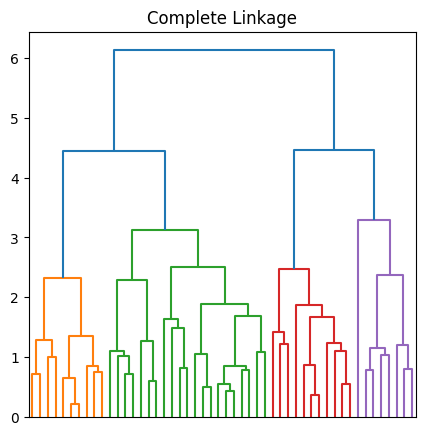

In [39]:
# scaling the variables

scaler = StandardScaler()
xsc = scaler.fit_transform(X)

hc_complete = linkage(data, method='complete')

plt.figure(figsize=(5, 5))
dendrogram(hc_complete, no_labels=True)
plt.title("Complete Linkage")

In [41]:
# correlating-based distance

X = np.random.randn(30, 3)
corr_mat = np.corrcoef(X, rowvar=False)
diss_matrix = 1 - corr_mat
dd = squareform(diss_matrix)
dd

array([0.85404828, 0.85339923, 0.81383615])

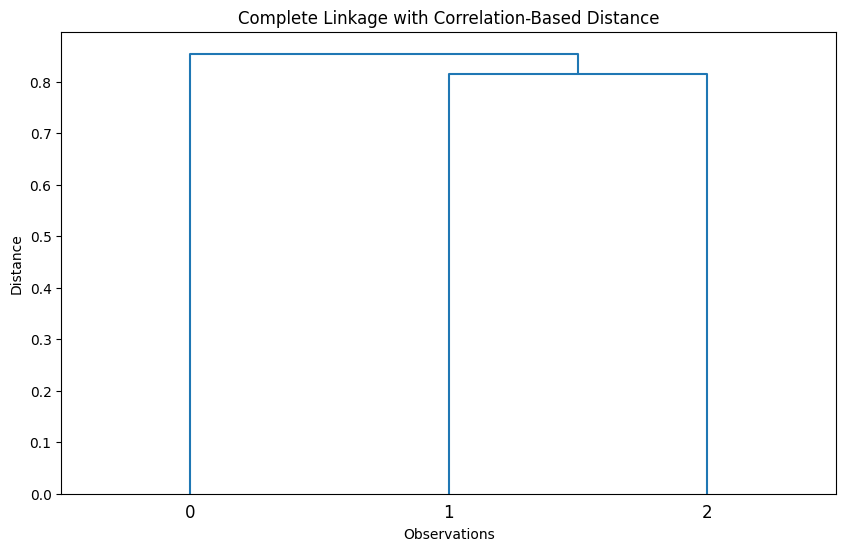

In [42]:
# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage(dd, method='complete'), labels=None)
plt.title("Complete Linkage with Correlation-Based Distance")
plt.xlabel("Observations")
plt.ylabel("Distance")
plt.show()

## 12.5.4 NCI60 Data Example

In [43]:
NCI60 = pd.read_csv('../data/NCI60.csv', index_col=0)

nci_labs = NCI60.labs
nci_data = NCI60.drop(['labs'], axis=1)

In [44]:
NCI60.head()

,data.1,data.2,data.3,data.4,data.5,data.6,data.7,data.8,data.9,data.10,...,data.6822,data.6823,data.6824,data.6825,data.6826,data.6827,data.6828,data.6829,data.6830,labs
V1,0.300000,1.180000,0.550000,1.140000,-0.265000,-7.000000e-02,0.350000,-0.315000,-0.450000,-0.654980,...,0.000000,0.030000,-0.175000,0.629981,-0.030000,0.000000,0.280000,-0.340000,-1.930000,CNS
V2,0.679961,1.289961,0.169961,0.379961,0.464961,5.799610e-01,0.699961,0.724961,-0.040039,-0.285019,...,-0.300039,-0.250039,-0.535039,0.109941,-0.860039,-1.250049,-0.770039,-0.390039,-2.000039,CNS
V3,0.940000,-0.040000,-0.170000,-0.040000,-0.605000,0.000000e+00,0.090000,0.645000,0.430000,0.475019,...,0.120000,-0.740000,-0.595000,-0.270020,-0.150000,0.000000,-0.120000,-0.410000,0.000000,CNS
V4,0.280000,-0.310000,0.680000,-0.810000,0.625000,-1.387779e-17,0.170000,0.245000,0.020000,0.095019,...,-0.110000,-0.160000,0.095000,-0.350019,-0.300000,-1.150010,1.090000,-0.260000,-1.100000,RENAL
V5,0.485000,-0.465000,0.395000,0.905000,0.200000,-5.000000e-03,0.085000,0.110000,0.235000,1.490019,...,-0.775000,-0.515000,-0.320000,0.634980,0.605000,0.000000,0.745000,0.425000,0.145000,BREAST


In [45]:
nci_data.shape

(64, 6830)

In [46]:
nci_labs[:4]

V1      CNS
V2      CNS
V3      CNS
V4    RENAL
Name: labs, dtype: object

### PCA on the NCI60 Data

In [47]:
scaler = StandardScaler()
nci_data_ = scaler.fit_transform(nci_data)

pca = PCA()
pca.fit(nci_data_)

PCA()

In [48]:
def cols(vec):
    unique_values = np.unique(vec)
    num_unique = len(unique_values)
    cols = plt.cm.rainbow(np.linspace(0, 1, num_unique))
    return cols[np.searchsorted(unique_values, vec)]

/var/folders/sf/m8d1jsv948q75r24_12s_sg00000gn/T/ipykernel_5348/4238509413.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)
/var/folders/sf/m8d1jsv948q75r24_12s_sg00000gn/T/ipykernel_5348/4238509413.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x[:, 0], x[:, 1], c=cols(nci_labs), cmap='rainbow', edgecolor='k', marker='o')
/var/folders/sf/m8d1jsv948q75r24_12s_sg00000gn/T/ipykernel_5348/4238509413.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x[:, 0], x[:, 2], c=cols(nci_labs), cmap='rainbow', edgecolor='k', marker='o')


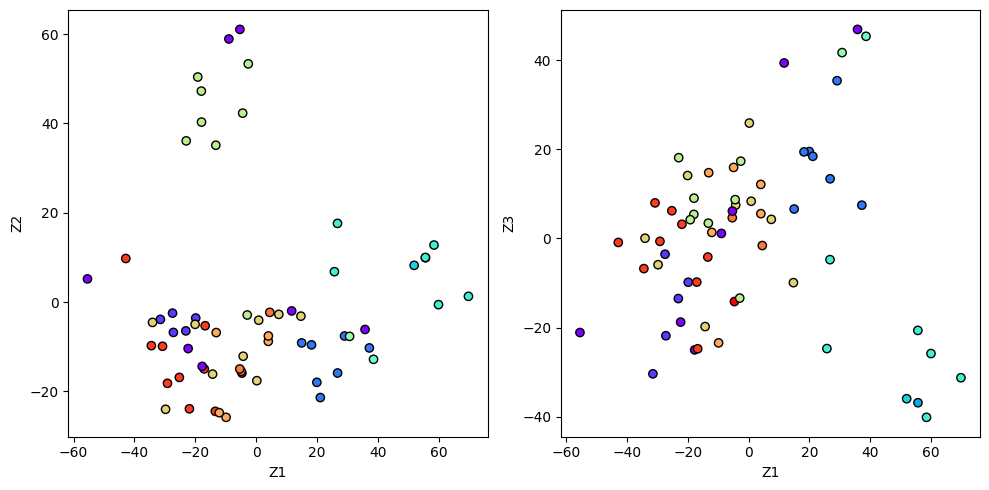

In [49]:
x = pca.transform(nci_data_)

plt.subplots(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.scatter(x[:, 0], x[:, 1], c=cols(nci_labs), cmap='rainbow', edgecolor='k', marker='o')
plt.xlabel("Z1")
plt.ylabel("Z2")

plt.subplot(1, 2, 2)
plt.scatter(x[:, 0], x[:, 2], c=cols(nci_labs), cmap='rainbow', edgecolor='k', marker='o')
plt.xlabel("Z1")
plt.ylabel("Z3")

plt.tight_layout()
plt.show()

On the whole, cell lines corresponding to a single cancer type do tend to have similar values on the first few principal component score vectors. This indicates that cell lines from the same cancer type tend to have pretty similar gene expression levels.

In [50]:
std_dev = np.sqrt(pca.explained_variance_)
pve = pca.explained_variance_ratio_
cum_pve = np.cumsum(pve)

summary = pd.DataFrame({
    'Standard Deviation': std_dev[:5],
    'Proportion of Variance': pve[:5],
    'Cumulative Proportion': cum_pve[:5]
}, index=['PC{}'.format(i + 1) for i in range(5)])

summary.T

,PC1,PC2,PC3,PC4,PC5
Standard Deviation,28.073658,21.651171,19.977151,17.167203,16.098068
Proportion of Variance,0.113589,0.067562,0.057518,0.042476,0.037350
Cumulative Proportion,0.113589,0.181151,0.238670,0.281145,0.318495


Text(0, 0.5, 'Cumulative Proportion of Variance Explained')

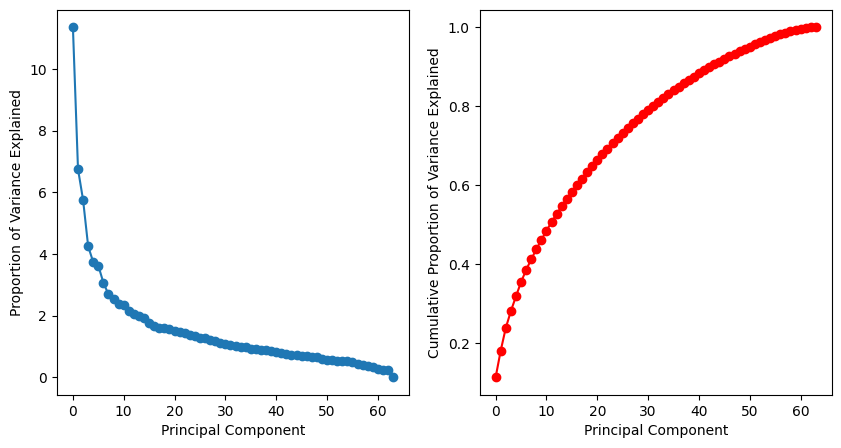

In [51]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(100*pve, marker='o')
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Proportion of Variance Explained')

ax[1].plot(np.cumsum(pve), marker='o', color='r')
ax[1].set_xlabel('Principal Component')
ax[1].set_ylabel('Cumulative Proportion of Variance Explained')

We see that together, the first seven principal com- ponents explain around 40 % of the variance in the data. This is not a huge amount of the variance. However, looking at the scree plot, we see that while each of the first seven principal components explain a substantial amount of variance, there is a marked decrease in the variance explained by further principal components. That is, there is an elbow in the plot after approximately the seventh principal component. This suggests that there may be little benefit to examining more than seven or so principal components.

### Clustering the Observations of the NCI60 Data

In [52]:
sd_data = scaler.fit_transform(nci_data)

In [53]:
hc_complete = linkage(sd_data, method='complete')
hc_average = linkage(sd_data, method='average')
hc_single = linkage(sd_data, method='single')

Text(0.5, 1.0, 'Complete Linkage')

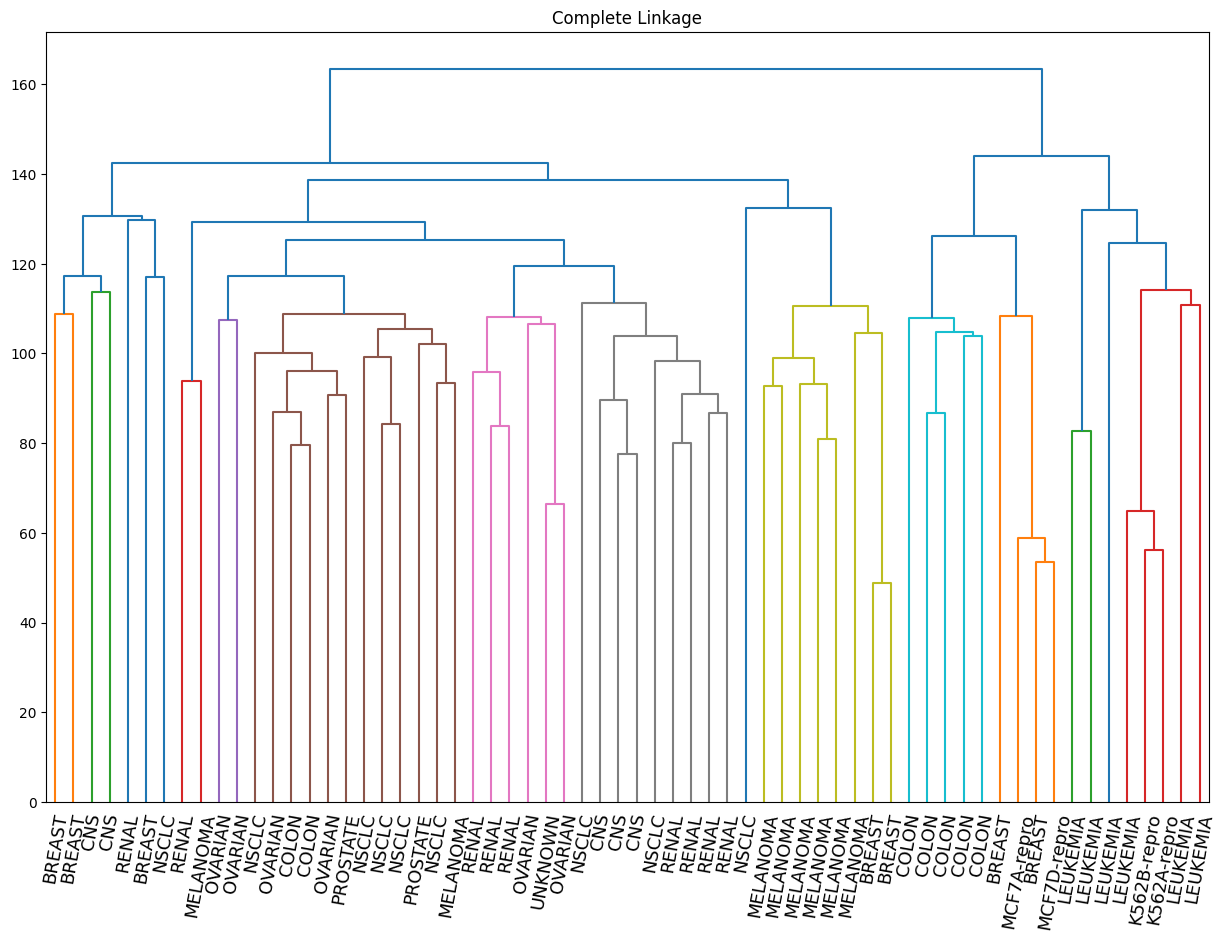

In [54]:
plt.figure(figsize=(15, 10))
dendrogram(hc_complete, labels=nci_labs,
           leaf_font_size=13, leaf_rotation=80)
plt.title('Complete Linkage')

Text(0.5, 1.0, 'Average Linkage')

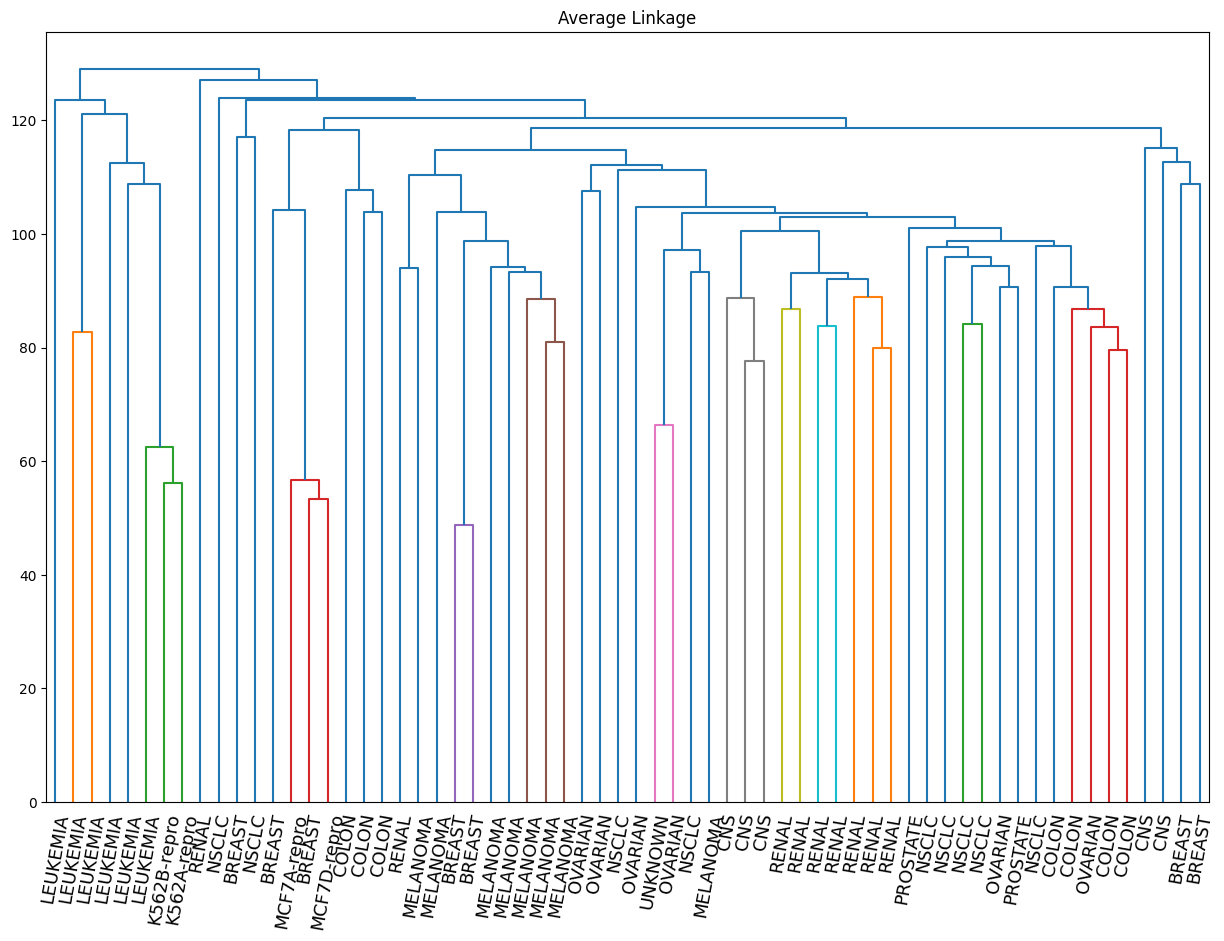

In [55]:
plt.figure(figsize=(15, 10))
dendrogram(hc_average, labels=nci_labs,
           leaf_font_size=13, leaf_rotation=80)
plt.title('Average Linkage')

Text(0.5, 1.0, 'Single Linkage')

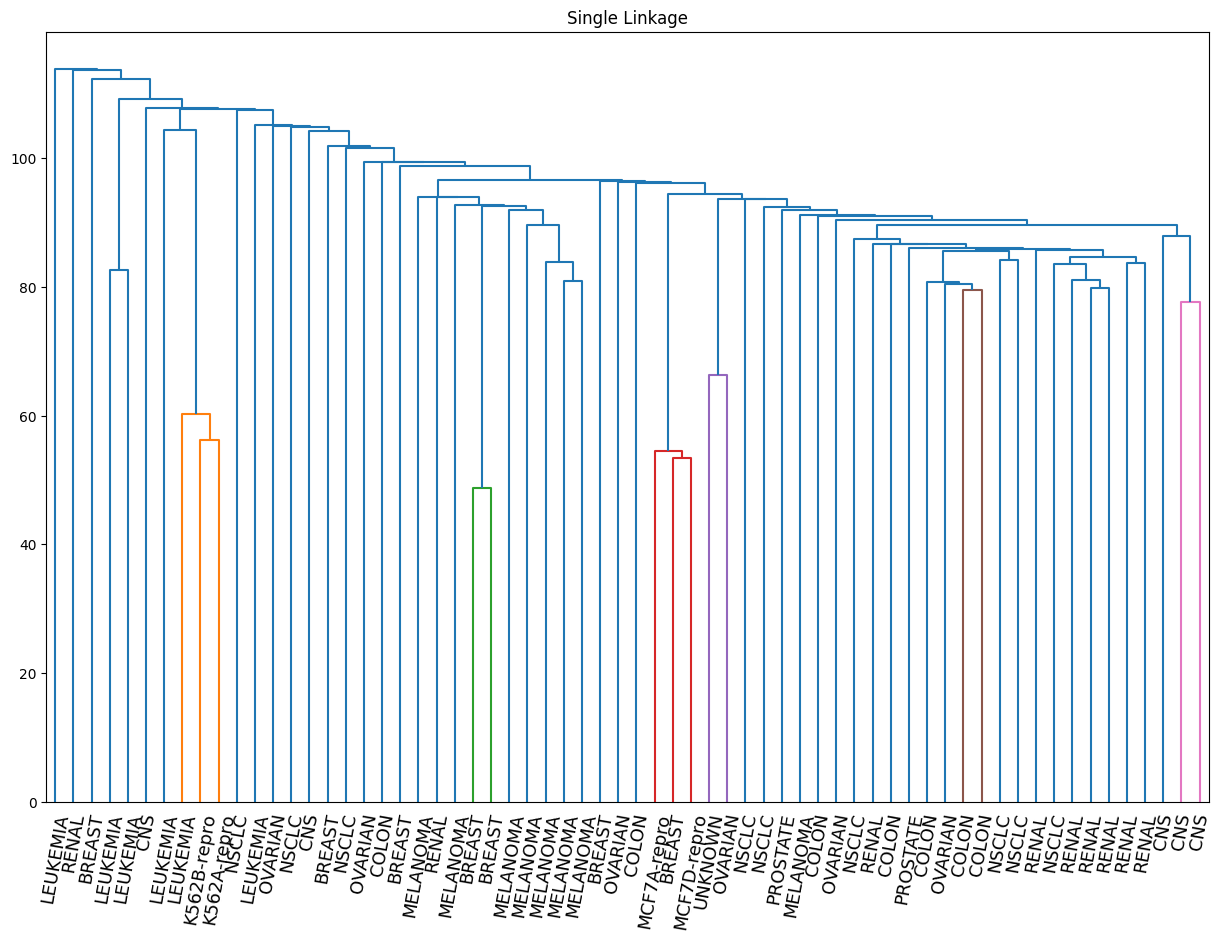

In [56]:
plt.figure(figsize=(15, 10))
dendrogram(hc_single, labels=nci_labs,
           leaf_font_size=13, leaf_rotation=80)
plt.title('Single Linkage')

In [57]:
hc_out = linkage(pdist(sd_data), method='complete')
hc_clusters = fcluster(hc_out, 4, criterion='maxclust')
pd.crosstab(hc_clusters, nci_labs)

labs,BREAST,CNS,COLON,K562A-repro,K562B-repro,LEUKEMIA,MCF7A-repro,MCF7D-repro,MELANOMA,NSCLC,OVARIAN,PROSTATE,RENAL,UNKNOWN
row_0,,,,,,,,,,,,,,
1,3,2,0,0,0,0,0,0,0,1,0,0,1,0
2,2,3,2,0,0,0,0,0,8,8,6,2,8,1
3,2,0,5,0,0,0,1,1,0,0,0,0,0,0
4,0,0,0,1,1,6,0,0,0,0,0,0,0,0


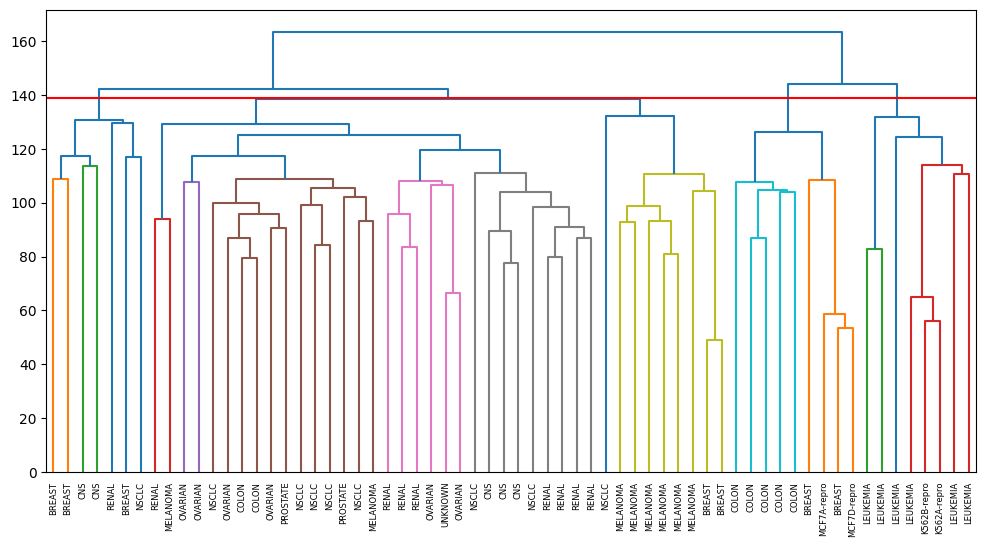

In [58]:
# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(hc_out, labels=nci_labs)

# Add a horizontal line at height 139 in red
plt.axhline(y=139, color="red")

plt.show()

How do these NCI60 hierarchical clustering results compare to what we get if we perform K-means clustering with K = 4?

In [59]:
kmeans = KMeans(n_clusters=4, n_init=20, random_state=2)
kmout = kmeans.fit(sd_data)
km_clusters = kmout.labels_

pd.crosstab(km_clusters, hc_clusters)

col_0,1,2,3,4
row_0,,,,
0,0,4,9,0
1,7,27,0,1
2,0,0,0,7
3,0,9,0,0


Rather than performing hierarchical clustering on the entire data matrix, we can simply perform hierarchical clustering on the first few principal component score vectors

Text(0.5, 1.0, 'Hier. Clust. on First Five Score Vectors')

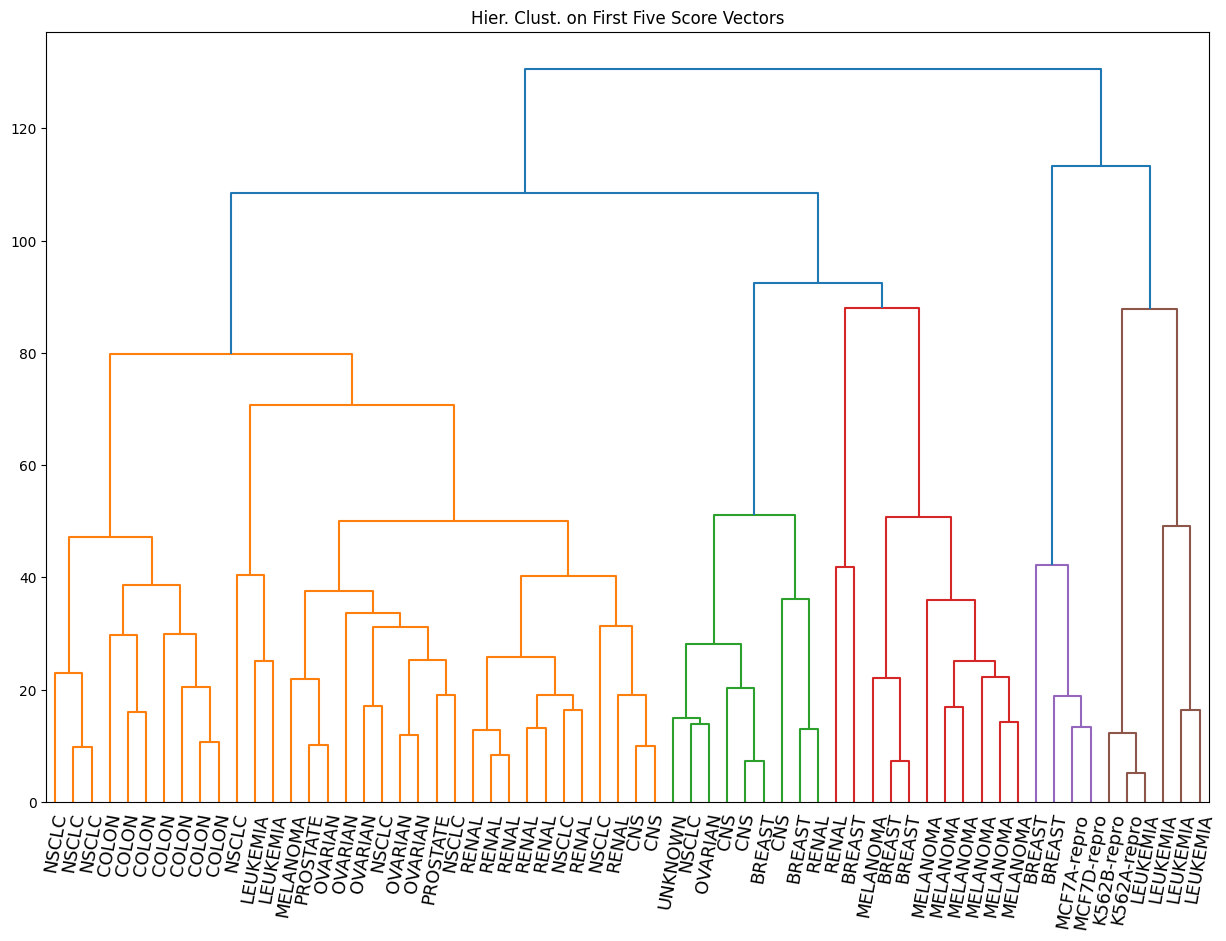

In [60]:
x = pca.transform(nci_data_)[:, :5]
hc_out = linkage(x, method='complete')

plt.figure(figsize=(15, 10))
dendrogram(hc_out, labels=nci_labs, 
          leaf_font_size=13, leaf_rotation=80)
plt.title("Hier. Clust. on First Five Score Vectors")

In [61]:
hc_clusters = fcluster(hc_out, 4, criterion='maxclust')
pd.crosstab(hc_clusters, nci_labs)

labs,BREAST,CNS,COLON,K562A-repro,K562B-repro,LEUKEMIA,MCF7A-repro,MCF7D-repro,MELANOMA,NSCLC,OVARIAN,PROSTATE,RENAL,UNKNOWN
row_0,,,,,,,,,,,,,,
1,0,2,7,0,0,2,0,0,1,8,5,2,7,0
2,5,3,0,0,0,0,0,0,7,1,1,0,2,1
3,2,0,0,0,0,0,1,1,0,0,0,0,0,0
4,0,0,0,1,1,4,0,0,0,0,0,0,0,0
